In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import tensorflow as tf

In [3]:
from keras.preprocessing.image import load_img, img_to_array

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import random

In [5]:
import imgaug.augmenters as iaa

In [6]:
import cv2

In [7]:
img_width, img_height = 216, 384

In [47]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 7
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def AHE(img):
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

In [36]:
aug1 = iaa.GaussianBlur(sigma=(0, 0.5))
aug2 = iaa.AdditiveGaussianNoise(scale=(0, 0.01 * 255))
transorfm_aug = iaa.PerspectiveTransform(scale=(0.001, 0.15))
affine = iaa.Affine(scale=(0.5, 1.5))

def additional_augmenation(image):
    image = aug1.augment_image(image)
    image = aug2.augment_image(image)
    image = transorfm_aug.augment_image(image)
    #image = affine.augment_image(image)
    return image

In [57]:
def preprocess_fcn(img):
    img = add_noise(img)
    return AHE(img)

def rotate_image(img):
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    return img

In [38]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.5, 2),
    validation_split=0.2,
    

    preprocessing_function=additional_augmenation,
)

In [54]:
class_names = ['brak', 'wada banderoli', 'wada nakretki', 'Ok nakrętka i banderola']

In [67]:
#train_generator = datagen.flow_from_directory('processed_dataset/nowy', batch_size=32, class_mode='categorical', seed = 123, subset='training', classes=class_names, shuffle=True)
train_generator = datagen.flow_from_directory('dataset/nakretka/processed/t', (img_height, img_width), batch_size=32, class_mode='categorical', seed = 123, subset='training', classes=class_names, shuffle=True)
val_generator = datagen.flow_from_directory('dataset/nakretka/processed/t', (img_height, img_width), batch_size=32, class_mode='categorical', seed = 123, subset='validation', classes=class_names, shuffle=True)

Found 1560 images belonging to 4 classes.
Found 389 images belonging to 4 classes.


In [17]:
help(train_generator)

Help on DirectoryIterator in module keras.preprocessing.image object:

class DirectoryIterator(keras_preprocessing.image.directory_iterator.DirectoryIterator, Iterator, keras.utils.data_utils.Sequence)
 |  DirectoryIterator(*args, **kwargs)
 |  
 |  Iterator capable of reading images from a directory on disk.
 |  
 |  Args:
 |      directory: Path to the directory to read images from.
 |          Each subdirectory in this directory will be
 |          considered to contain images from one class,
 |          or alternatively you could specify class subdirectories
 |          via the `classes` argument.
 |      image_data_generator: Instance of `ImageDataGenerator`
 |          to use for random transformations and normalization.
 |      target_size: tuple of integers, dimensions to resize input images to.
 |      color_mode: One of `"rgb"`, `"rgba"`, `"grayscale"`.
 |          Color mode to read images.
 |      classes: Optional list of strings, names of subdirectories
 |          contai

In [68]:
from collections import Counter

print("Training")
print(train_generator.class_indices)
print(Counter(train_generator.classes))
print("Validation")
print(val_generator.class_indices)
print(Counter(val_generator.classes))

num_classes = len(class_names)

Training
{'brak': 0, 'wada banderoli': 1, 'wada nakretki': 2, 'Ok nakrętka i banderola': 3}
Counter({1: 1560})
Validation
{'brak': 0, 'wada banderoli': 1, 'wada nakretki': 2, 'Ok nakrętka i banderola': 3}
Counter({1: 389})


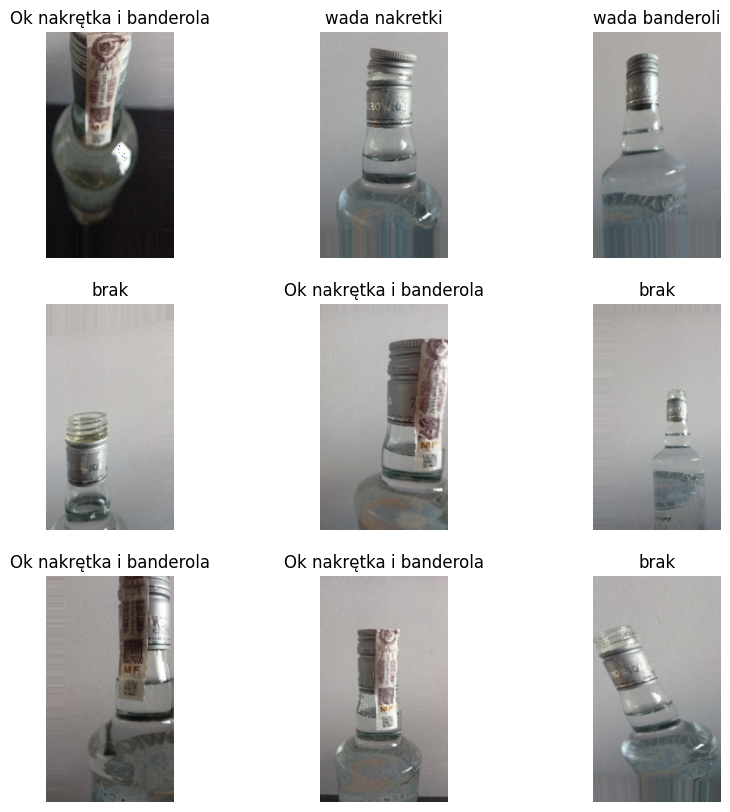

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for gen in range(3):
    x,y = train_generator.next()

    for i in range(3):
        ax = plt.subplot(3, 3, gen * 3 + i + 1)
        plt.imshow(x[i].astype("uint8"))
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")

plt.show()

In [58]:
def create_model(num_classes):

    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(2, 2),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.summary()

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])
    
    return model

In [59]:
model = create_model(num_classes)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 382, 214, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 191, 107, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 189, 105, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 94, 52, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 92, 50, 64)        18496     
                                                                 
 conv2d_30 (Conv2D)          (None, 90, 48, 64)       

In [21]:
help(model.fit)

Help on method fit in module keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False) method of keras.engine.sequential.Sequential instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    Args:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset. Should return a tuple
            of either `(inp

In [69]:
epochs = 10

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='4_klasy.{epoch:02d}-{val_loss:.2f}.h5'),
]

history=model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=my_callbacks)

Epoch 1/10
18/49 [==========>...................] - ETA: 54s - loss: 0.0246 - accuracy: 0.9912

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


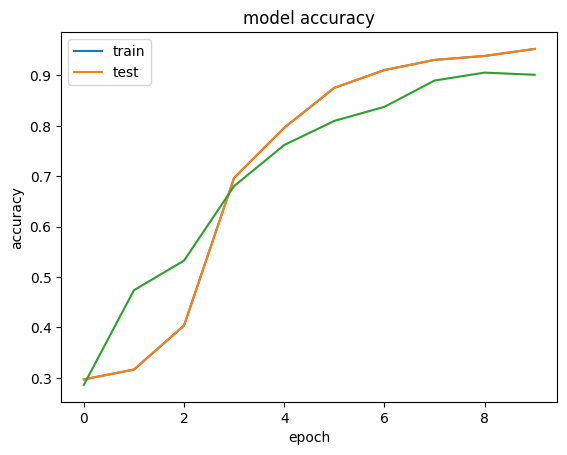

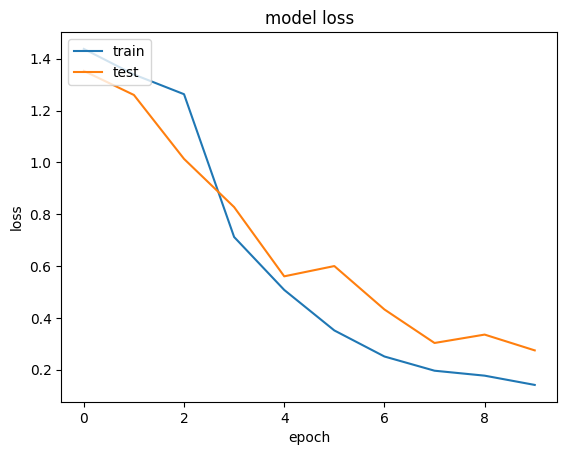

In [63]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

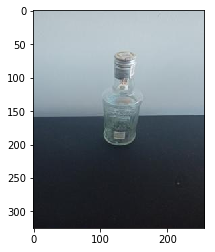

In [17]:
plt.imshow(X[0])

In [14]:
from PIL import Image

In [15]:
def make_prediction(src, model, show_image):
    for root, subdirs, files in os.walk(src):
        for images in files:
            img = Image.open(root + images)
            img = img.resize((img_width, img_height))
            if(show_image):
                img.show()
            #img = np.array(img).astype('float32')
            #img = img / 255.0
            X_to_predict = np.expand_dims(img, axis=0)
            y_pred = model.predict(X_to_predict)[0]
            prediction_class = y_pred.argmax()
            prediction_confidence = y_pred[prediction_class]
            
            print(prediction_class)
            print(prediction_confidence)
            print(class_names[prediction_class])
            print(y_pred)
            

print(class_names)

['almost_full', 'empty_bottle', 'full_bottle', 'none']


In [70]:
model.save('4_klasy_nakretki.h5')

In [11]:
from keras.models import load_model

# Do odczytu

In [12]:
model2 = load_model('trening_91.h5')

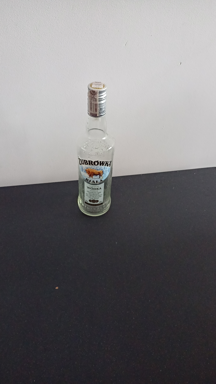

2
0.99861646
full_bottle
[1.3490749e-03 3.4454300e-05 9.9861646e-01 5.9860944e-10]


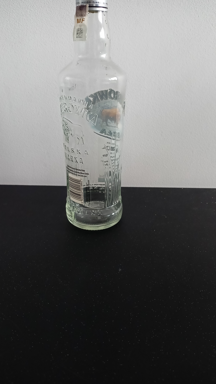

0
0.9999975
almost_full
[9.9999750e-01 7.2303691e-11 2.5370980e-06 5.9134343e-15]


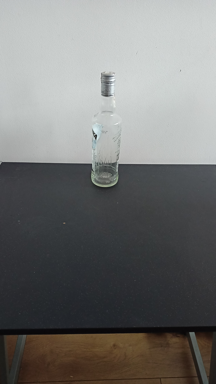

1
1.0
empty_bottle
[1.0315094e-11 1.0000000e+00 2.3170469e-12 3.0940203e-14]


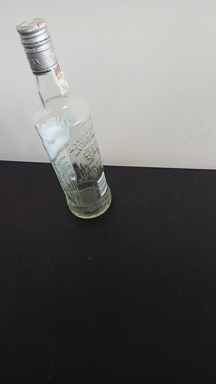

0
0.99999964
almost_full
[9.9999964e-01 7.3677833e-09 3.3130121e-07 4.6588513e-14]


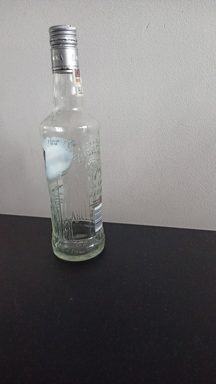

0
0.999985
almost_full
[9.999850e-01 6.004462e-09 1.504148e-05 3.960670e-12]


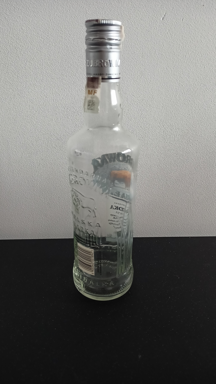

1
0.99984324
empty_bottle
[1.5654540e-04 9.9984324e-01 2.8059333e-07 6.0211103e-09]


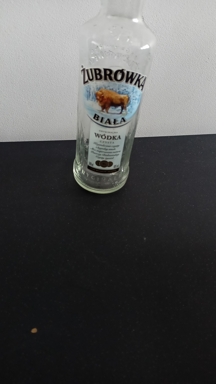

1
1.0
empty_bottle
[3.1340270e-15 1.0000000e+00 1.7650289e-18 1.1650756e-23]


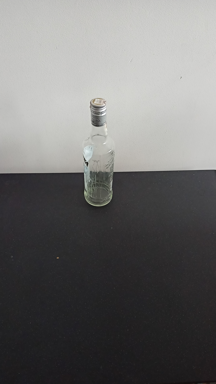

1
0.9999963
empty_bottle
[2.6086607e-07 9.9999630e-01 3.4621009e-06 4.7856212e-13]


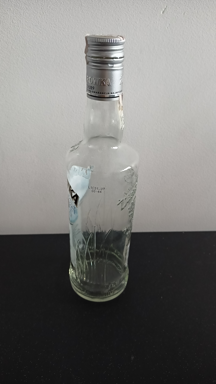

1
0.99985087
empty_bottle
[1.4913866e-04 9.9985087e-01 2.8016613e-14 1.7244571e-18]


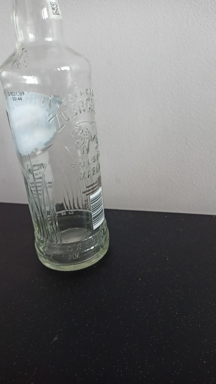

2
0.9859406
full_bottle
[1.4055944e-02 3.5228270e-06 9.8594058e-01 4.5523208e-08]


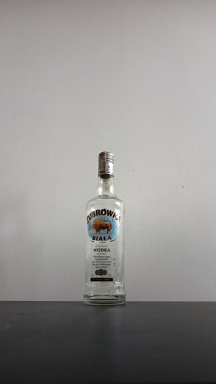

2
0.97009045
full_bottle
[2.7826933e-02 2.0826003e-03 9.7009045e-01 9.2396819e-12]


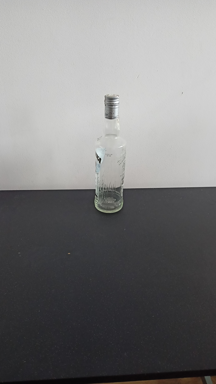

1
0.9998914
empty_bottle
[2.8659662e-05 9.9989140e-01 7.9939600e-05 2.6345606e-10]


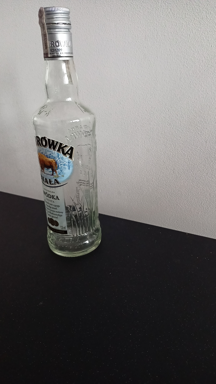

0
1.0
almost_full
[1.0000000e+00 1.7909909e-12 5.3459431e-08 3.8833082e-19]


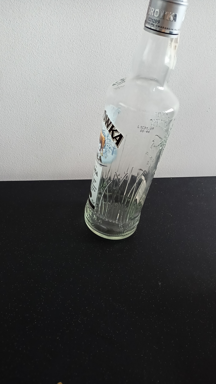

0
0.9239343
almost_full
[9.2393428e-01 4.0905015e-04 7.5656720e-02 2.0059440e-10]


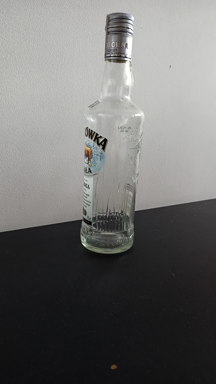

0
1.0
almost_full
[1.00000000e+00 1.08401524e-10 7.61427379e-13 8.15444236e-25]


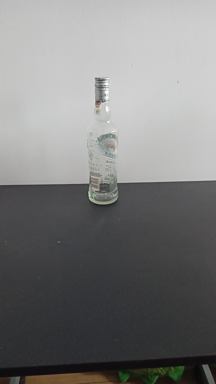

2
0.8617454
full_bottle
[6.455189e-02 7.370231e-02 8.617454e-01 3.980539e-07]


In [16]:
make_prediction('dataset/testy_butelka/Puste/', model, True)